In [ ]:
!pip install tensorflow_datasets

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
import random

import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
dataset = tfds.load('amazon_us_reviews/Watches_v1_00', split='train', shuffle_files=True)

2023-03-18 00:14:03.855982: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/sunilthapa/tensorflow_datasets/amazon_us_reviews/Watches_v1_00/0.1.0.incomplete5A2LWM/amazon_…

Dataset amazon_us_reviews downloaded and prepared to /Users/sunilthapa/tensorflow_datasets/amazon_us_reviews/Watches_v1_00/0.1.0. Subsequent calls will reuse this data.


In [3]:
df = tfds.as_dataframe(dataset)

2023-03-18 00:28:40.836504: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
df.to_csv('Watches_v1_00.csv')

In [88]:
df = pd.read_csv('Watches_v1_00.csv')

In [36]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'helpful_votes', 'marketplace',
       'product_category', 'product_id', 'product_parent', 'product_title',
       'review_body', 'review_date', 'review_headline', 'review_id',
       'star_rating', 'total_votes', 'verified_purchase', 'vine'],
      dtype='object')

In [37]:
df.drop(columns='Unnamed: 0', inplace=True)

In [38]:
df.drop(columns=['review_id','product_id','vine','product_parent','review_headline'],inplace=True)

In [51]:
df.head()

,customer_id,helpful_votes,marketplace,product_category,product_title,review_body,review_date,star_rating,total_votes,verified_purchase,review_length
0,b'40915676',0,b'US',b'Watches',"b""U.S. Polo Assn. Sport Men's US9057 Black Met...","b""It's exactly how it looks like, the colors a...",b'2013-12-24',5,0,0,110
1,b'42279473',0,b'US',b'Watches',b'Burberry Mens BU7818 Utilitarian Black Leath...,b'Very happy!',b'2014-08-01',5,1,0,14
2,b'44311301',2,b'US',b'Watches',"b""Invicta Men's 5249S Pro Diver Stainless Stee...",b'Bought this watch for my husband as a weddin...,b'2013-06-13',1,2,0,183
3,b'42616791',0,b'US',b'Watches',"b""XOXO Women's XO3041 Black Dial Black Strap W...",b'A great Watch for my Nurse wife. This is Ok ...,b'2012-06-11',5,0,0,137
4,b'37080317',1,b'US',b'Watches',"b""Sector Men's R3253161003 Marine Stainless St...","b""I've had a sector diver watch before ,it la...",b'2014-07-20',5,1,0,107


In [68]:
df.dtypes

customer_id          object
helpful_votes         int64
marketplace          object
product_category     object
product_title        object
review_body          object
review_date          object
star_rating           int64
total_votes           int64
verified_purchase     int64
review_length         int64
dtype: object

In [67]:
df['product_title'][0][1:][1:-1]

"U.S. Polo Assn. Sport Men's US9057 Black Metal Watch with Orange Rubber Band"

In [69]:
for d in df:
    if df[d].dtype != 'int64':
        df[d] = df[d].apply(lambda x: x[1:][1:-1])

In [70]:
df.head()

,customer_id,helpful_votes,marketplace,product_category,product_title,review_body,review_date,star_rating,total_votes,verified_purchase,review_length
0,40915676,0,US,Watches,U.S. Polo Assn. Sport Men's US9057 Black Metal...,"It's exactly how it looks like, the colors are...",2013-12-24,5,0,0,110
1,42279473,0,US,Watches,Burberry Mens BU7818 Utilitarian Black Leather...,Very happy!,2014-08-01,5,1,0,14
2,44311301,2,US,Watches,Invicta Men's 5249S Pro Diver Stainless Steel ...,Bought this watch for my husband as a wedding ...,2013-06-13,1,2,0,183
3,42616791,0,US,Watches,XOXO Women's XO3041 Black Dial Black Strap Watch,A great Watch for my Nurse wife. This is Ok bu...,2012-06-11,5,0,0,137
4,37080317,1,US,Watches,Sector Men's R3253161003 Marine Stainless Stee...,"I've had a sector diver watch before ,it last...",2014-07-20,5,1,0,107


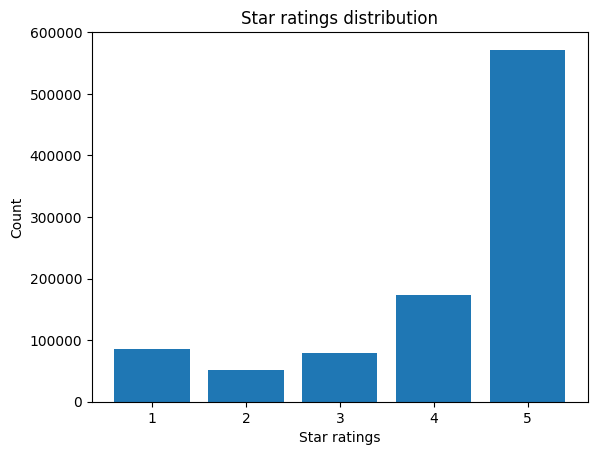

In [44]:
star_ratings_count = df['star_rating'].value_counts().sort_index()

# Plot a bar chart
plt.bar(star_ratings_count.index, star_ratings_count.values)

# Add labels and title
plt.xlabel('Star ratings')
plt.ylabel('Count')
plt.title('Star ratings distribution')

# Show the chart
plt.show()

In [40]:
df['verified_purchase'].value_counts()

0    831415
1    129457
Name: verified_purchase, dtype: int64

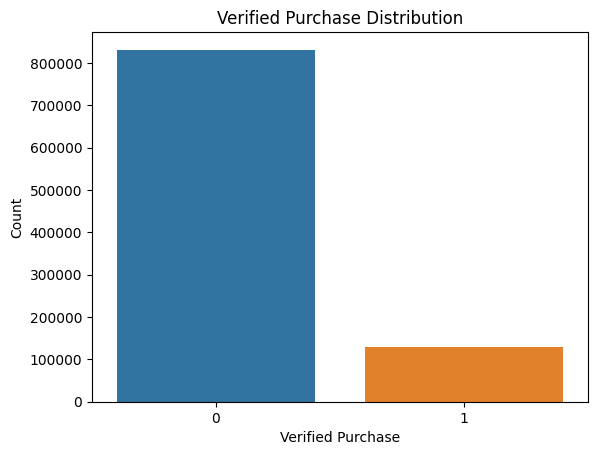

In [45]:
# Create a countplot using Seaborn
sns.countplot(x='verified_purchase', data=df)

# Add labels and title
plt.xlabel('Verified Purchase')
plt.ylabel('Count')
plt.title('Verified Purchase Distribution')

# Show the chart
plt.show()

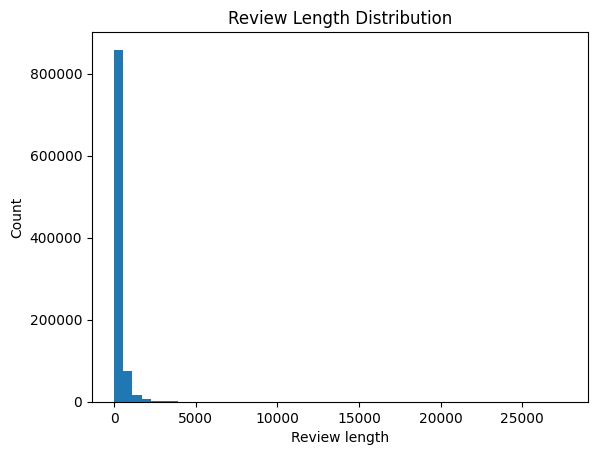

In [46]:
# Calculate the length of each review
df['review_length'] = df['review_body'].apply(len)

# Create a histogram of review lengths
plt.hist(df['review_length'], bins=50)

# Add labels and title
plt.xlabel('Review length')
plt.ylabel('Count')
plt.title('Review Length Distribution')

# Show the chart
plt.show()

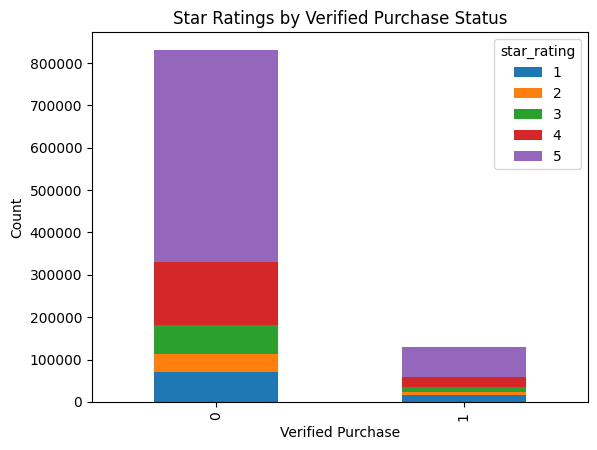

In [47]:
# Group the data by verified purchase and star rating
grouped = df.groupby(['verified_purchase', 'star_rating']).size().unstack()

# Create a stacked bar chart of star ratings by verified purchase
grouped.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Verified Purchase')
plt.ylabel('Count')
plt.title('Star Ratings by Verified Purchase Status')

# Show the chart
plt.show()

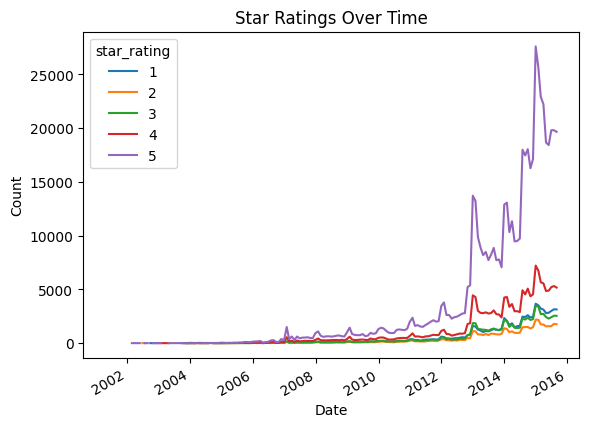

In [71]:
# Convert the review_date column to a datetime object
df['review_date'] = pd.to_datetime(df['review_date'], format='%Y-%m-%d')

# Group the data by review date and star rating
grouped = df.groupby([pd.Grouper(key='review_date', freq='M'), 'star_rating']).size().unstack()

# Create a line chart of star ratings over time
grouped.plot()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Star Ratings Over Time')

# Show the chart
plt.show()

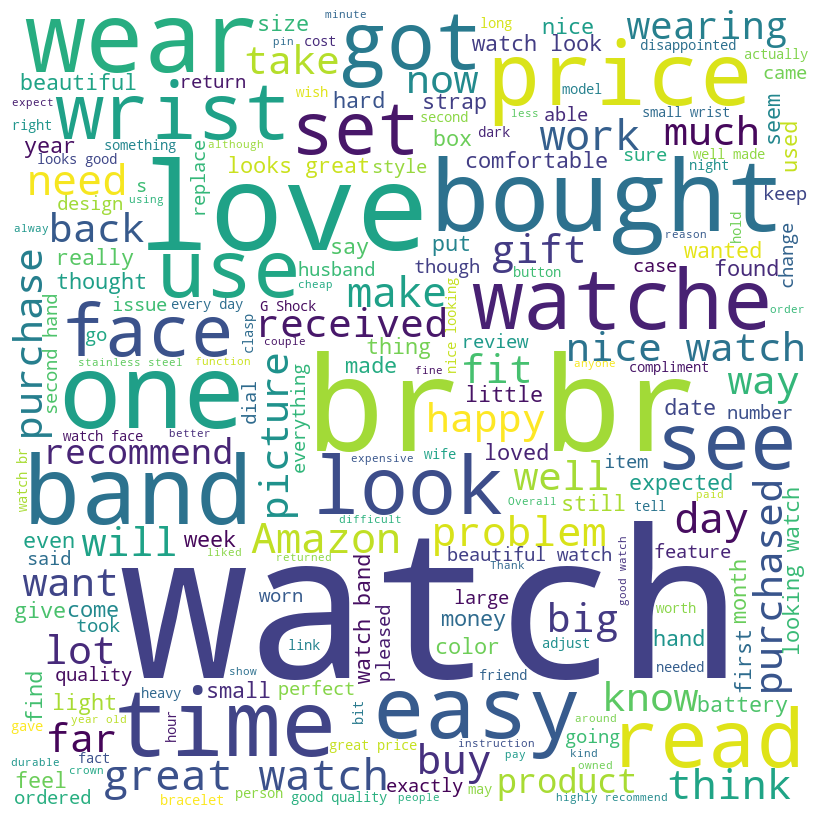

In [74]:
# Combine all review bodies into a single string
all_reviews = ' '.join(df['review_body'].tolist())

# Create a word cloud of the most frequent words
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

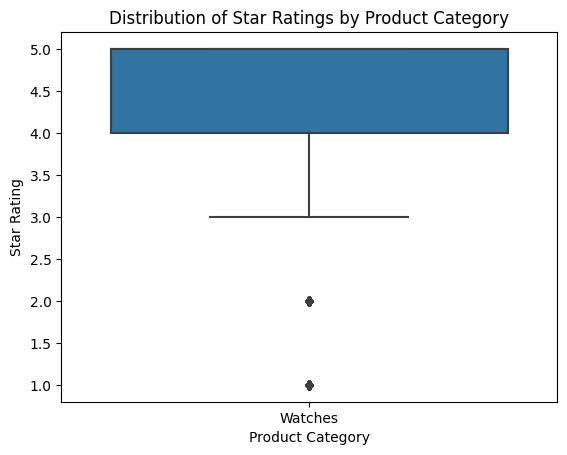

In [75]:
# Create a box plot of star ratings by product category
sns.boxplot(x='product_category', y='star_rating', data=df)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Star Rating')
plt.title('Distribution of Star Ratings by Product Category')

# Show the chart
plt.show()

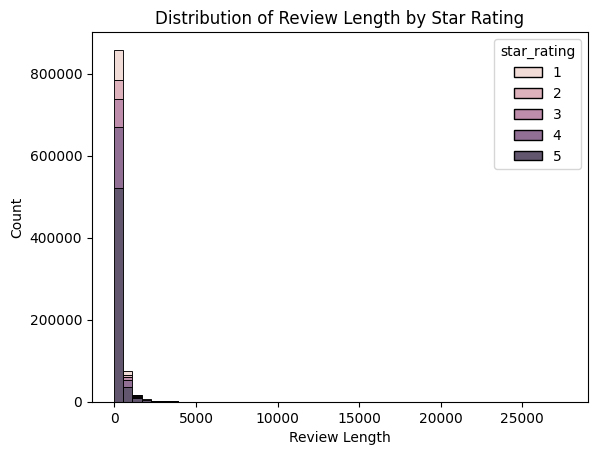

In [76]:
# Create a new column with the length of each review body
df['review_length'] = df['review_body'].apply(len)

# Create a histogram of review length by star rating
sns.histplot(x='review_length', hue='star_rating', data=df, multiple='stack', bins=50)

# Add labels and title
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.title('Distribution of Review Length by Star Rating')

# Show the chart
plt.show()

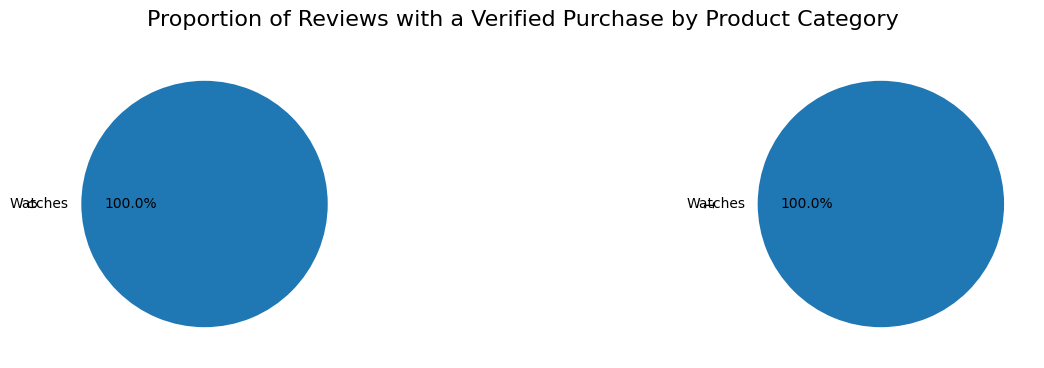

In [77]:
# Group the dataframe by product category and calculate the proportion of reviews with a verified purchase
grouped_df = df.groupby('product_category')['verified_purchase'].value_counts(normalize=True).unstack().fillna(0)

# Create a pie chart of the proportion of reviews with a verified purchase by product category
grouped_df.plot(kind='pie', subplots=True, figsize=(16, 4), autopct='%1.1f%%', legend=False)

# Add title
plt.suptitle('Proportion of Reviews with a Verified Purchase by Product Category', fontsize=16)

# Show the chart
plt.show()

In [105]:
df["Sentiment"] = df["star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
df['Sentiment'] = df['Sentiment'].map({'positive':1, 'negative':0})
# df['short_review'] =df['review_body'].str.decode("utf-8")
df['short_review'] =df['review_body']

In [106]:
neg_df = df[df['Sentiment'] == 0].head(20000)
pos_df = df[df['Sentiment'] == 1].head(20000)
dfs = [neg_df, pos_df]
random.shuffle(dfs)
new_df = pd.concat(dfs)

In [107]:
new_df.shape

(40000, 18)

In [108]:
new_df['Sentiment'].value_counts()

1    20000
0    20000
Name: Sentiment, dtype: int64

In [109]:
new_df.isnull().sum()

Unnamed: 0           0
customer_id          0
helpful_votes        0
marketplace          0
product_category     0
product_id           0
product_parent       0
product_title        0
review_body          0
review_date          0
review_headline      0
review_id            0
star_rating          0
total_votes          0
verified_purchase    0
vine                 0
Sentiment            0
short_review         0
dtype: int64

In [110]:
new_df.to_csv('dataset_40k.csv')

## Data Wrangling

In [2]:
df = pd.read_csv('dataset_40k.csv')

In [3]:
df = df[['Sentiment', 'short_review']]

In [4]:
df.head()

,Sentiment,short_review
0,1,"b""It's exactly how it looks like, the colors a..."
1,1,b'Very happy!'
2,1,b'A great Watch for my Nurse wife. This is Ok ...
3,1,"b""I've had a sector diver watch before ,it la..."
4,1,"b""I have several different models. This is my ..."


In [5]:
df['Sentiment'].value_counts()

1    20000
0    20000
Name: Sentiment, dtype: int64

In [6]:
df.shape

(40000, 2)

In [7]:
df.sample

<bound method NDFrame.sample of        Sentiment                                       short_review
0              1  b"It's exactly how it looks like, the colors a...
1              1                                     b'Very happy!'
2              1  b'A great Watch for my Nurse wife. This is Ok ...
3              1  b"I've  had a sector diver watch before ,it la...
4              1  b"I have several different models. This is my ...
...          ...                                                ...
39995          0  b"It's a shorter band then others I've purchas...
39996          0  b"Save yourself and do not buy anything from t...
39997          0  b"Watch didn't work and took over a week to co...
39998          0  b'Timex watch arrived but did not have the chr...
39999          0  b"I didn't get to wear it for only a couple of...

[40000 rows x 2 columns]>

In [8]:
for d in df:
    if df[d].dtype != 'int64':
        df[d] = df[d].apply(lambda x: x[1:][1:-1])

In [9]:
df.sample(10)

,Sentiment,short_review
24925,0,Purchased watch for special friend before Chri...
33717,0,"not good ,not working"
37518,0,Stopped working after 3 months..........I brou...
4519,1,"This is a great watch - lightweight, slim prof..."
33396,0,"Dead on arrival. With minimal force applied, t..."
18876,1,i have had this watch for about 6 months and i...
26662,0,Too heavy and clip is difficult to use with a ...
35537,0,the watch leaks in the shower
37749,0,I loved this watch. It looks great and looks ...
832,1,I bought the Tag Heuer Aquaracer Chronograph W...


In [10]:
pattern = '&(amp|lt|gt);?'
pattern_replace_map = {
    '&lt;': '<',
    '&gt;': '>',
    '&amp;': 'and'
}

# Define a function to replace the matches with their corresponding values
def replace_match(match):
    return pattern_replace_map[match.group(0)]


def review_process(review_text: str) -> str:
    """
        Processes the review text to remove any non-ascii characters.
        
        ### Parameters:
        text: str
            review text

        ### Returns:
        str:
            A string only containing ascii characters 
    """
    review_text = re.sub('https://\S+|http://\S+', '', review_text) # Remove whole links
    review_text = re.sub(pattern, replace_match, review_text) # Converting html tags references
    review_text = re.sub('\d+', '', review_text) # removing numbers from text
    # Remove new lines, mentions, hastags, and multiple spaces
    review_text = re.sub('[\r\n]+', ' ', review_text)
    review_text = re.sub(r'@\w+', '', review_text)
    review_text = re.sub(r'#\w+', '', review_text)
    review_text = re.sub('\s+', ' ', review_text)
    review_text = re.sub(r"\b\d{4}-\d{2}-\d{2}\b|\b\d{2}:\d{2}:\d{2}\b", "", review_text) # Remove datetime string
    return review_text.lower()

In [11]:
df['processed_review'] = df['short_review'].apply(review_process)

In [12]:
df

,Sentiment,short_review,processed_review
0,1,"It's exactly how it looks like, the colors are...","it's exactly how it looks like, the colors are..."
1,1,Very happy!,very happy!
2,1,A great Watch for my Nurse wife. This is Ok bu...,a great watch for my nurse wife. this is ok bu...
3,1,"I've had a sector diver watch before ,it last...","i've had a sector diver watch before ,it laste..."
4,1,I have several different models. This is my cu...,i have several different models. this is my cu...
...,...,...,...
39995,0,It's a shorter band then others I've purchased...,it's a shorter band then others i've purchased...
39996,0,Save yourself and do not buy anything from thi...,save yourself and do not buy anything from thi...
39997,0,Watch didn't work and took over a week to cont...,watch didn't work and took over a week to cont...
39998,0,Timex watch arrived but did not have the chron...,timex watch arrived but did not have the chron...


In [13]:
# Keeping only english words
pattern = r'[^\x00-\x7F]+'
def keep_english_words(text: str) -> str:
    """
        Keep only english words in the text.

        ### Parameters:
        text: str
            Tweet text

        ### Returns:
        str: 
            A string only containing english words 
    """
    return re.sub(pattern, '', text)

In [14]:
df['processed_review'] = df['processed_review'].apply(keep_english_words)

In [15]:
df.loc[35623]

Sentiment                                                           0
short_review        **Update**<br />06/10/13<br />Less than 6 mont...
processed_review    **update**<br />//<br />less than months after...
Name: 35623, dtype: object

In [16]:
def remove_html_rag(text):
    temp_1 = re.findall(r'<[a-zA-Z]+\s{0,}>', text)
    temp_2 = re.findall(r'<[a-zA-Z]+\s{0,}/>', text)
    temp_list = temp_1 + temp_2
    for item in temp_list:
        text = text.replace(item, ' ')
    
    return text
    
    

In [17]:
# Removing html tags
df['processed_review'] = df['processed_review'].apply(remove_html_rag)

In [18]:
df.loc[35623]

Sentiment                                                           0
short_review        **Update**<br />06/10/13<br />Less than 6 mont...
processed_review    **update** // less than months after purchasin...
Name: 35623, dtype: object

In [19]:
def remove_punct(text: str) -> str:
    """
        Remove punctuation from a string.

        ### Parameters 
        text: str 
            The string to remove punctuation from.

        ### Returns
        text: str
            The string with punctuation removed.
    """
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    return text

In [20]:
# Removing Punctuation
df['remove_punct'] = df['processed_review'].apply(remove_punct)

In [21]:
df.head()

,Sentiment,short_review,processed_review,remove_punct
0,1,"It's exactly how it looks like, the colors are...","it's exactly how it looks like, the colors are...",its exactly how it looks like the colors are b...
1,1,Very happy!,very happy!,very happy
2,1,A great Watch for my Nurse wife. This is Ok bu...,a great watch for my nurse wife. this is ok bu...,a great watch for my nurse wife this is ok but...
3,1,"I've had a sector diver watch before ,it last...","i've had a sector diver watch before ,it laste...",ive had a sector diver watch before it lasted ...
4,1,I have several different models. This is my cu...,i have several different models. this is my cu...,i have several different models this is my cur...


In [22]:
df.loc[35623]

Sentiment                                                           0
short_review        **Update**<br />06/10/13<br />Less than 6 mont...
processed_review    **update** // less than months after purchasin...
remove_punct        update  less than months after purchasing this...
Name: 35623, dtype: object

In [23]:
# tokenized
df['tokenized'] = df['remove_punct'].apply(word_tokenize)
df.head()

,Sentiment,short_review,processed_review,remove_punct,tokenized
0,1,"It's exactly how it looks like, the colors are...","it's exactly how it looks like, the colors are...",its exactly how it looks like the colors are b...,"[its, exactly, how, it, looks, like, the, colo..."
1,1,Very happy!,very happy!,very happy,"[very, happy]"
2,1,A great Watch for my Nurse wife. This is Ok bu...,a great watch for my nurse wife. this is ok bu...,a great watch for my nurse wife this is ok but...,"[a, great, watch, for, my, nurse, wife, this, ..."
3,1,"I've had a sector diver watch before ,it last...","i've had a sector diver watch before ,it laste...",ive had a sector diver watch before it lasted ...,"[ive, had, a, sector, diver, watch, before, it..."
4,1,I have several different models. This is my cu...,i have several different models. this is my cu...,i have several different models this is my cur...,"[i, have, several, different, models, this, is..."


In [24]:
stopwords = set(stopwords.words("english"))

def remove_stopwords(text: list) -> list:
    """
        Removes stopwords from text.

        ### Parameters
        text: str 
            list of words
        
        ### Returns
        list:
            list of words without stopwords
    """
    text_list = [word for word in text if word.lower() not in stopwords]
    return text_list

In [25]:
# Removing stopwords
df['remove_stopwords'] = df['tokenized'].apply(remove_stopwords)
df

,Sentiment,short_review,processed_review,remove_punct,tokenized,remove_stopwords
0,1,"It's exactly how it looks like, the colors are...","it's exactly how it looks like, the colors are...",its exactly how it looks like the colors are b...,"[its, exactly, how, it, looks, like, the, colo...","[exactly, looks, like, colors, bright, cant, w..."
1,1,Very happy!,very happy!,very happy,"[very, happy]",[happy]
2,1,A great Watch for my Nurse wife. This is Ok bu...,a great watch for my nurse wife. this is ok bu...,a great watch for my nurse wife this is ok but...,"[a, great, watch, for, my, nurse, wife, this, ...","[great, watch, nurse, wife, ok, expendable, lo..."
3,1,"I've had a sector diver watch before ,it last...","i've had a sector diver watch before ,it laste...",ive had a sector diver watch before it lasted ...,"[ive, had, a, sector, diver, watch, before, it...","[ive, sector, diver, watch, lasted, years, sec..."
4,1,I have several different models. This is my cu...,i have several different models. this is my cu...,i have several different models this is my cur...,"[i, have, several, different, models, this, is...","[several, different, models, current, favorite..."
...,...,...,...,...,...,...
39995,0,It's a shorter band then others I've purchased...,it's a shorter band then others i've purchased...,its a shorter band then others ive purchasedst...,"[its, a, shorter, band, then, others, ive, pur...","[shorter, band, others, ive, purchasedstrap, b..."
39996,0,Save yourself and do not buy anything from thi...,save yourself and do not buy anything from thi...,save yourself and do not buy anything from thi...,"[save, yourself, and, do, not, buy, anything, ...","[save, buy, anything, seller, first, products,..."
39997,0,Watch didn't work and took over a week to cont...,watch didn't work and took over a week to cont...,watch didnt work and took over a week to conta...,"[watch, didnt, work, and, took, over, a, week,...","[watch, didnt, work, took, week, contact, some..."
39998,0,Timex watch arrived but did not have the chron...,timex watch arrived but did not have the chron...,timex watch arrived but did not have the chron...,"[timex, watch, arrived, but, did, not, have, t...","[timex, watch, arrived, chrono, function, use,..."


In [26]:
def get_pos_tag(text_list: list) -> list:
    """
        Returns a list of POS tags for the given list of words.

        ### Parameters
        text_list: list
            A list of words

        ### Returns
        list:
            A list of POS tags
    """
    return nltk.pos_tag(text_list)

In [27]:
# getting part of speech 
df['pos_tag'] = df['remove_stopwords'].apply(get_pos_tag)
df.head()

,Sentiment,short_review,processed_review,remove_punct,tokenized,remove_stopwords,pos_tag
0,1,"It's exactly how it looks like, the colors are...","it's exactly how it looks like, the colors are...",its exactly how it looks like the colors are b...,"[its, exactly, how, it, looks, like, the, colo...","[exactly, looks, like, colors, bright, cant, w...","[(exactly, RB), (looks, VBZ), (like, IN), (col..."
1,1,Very happy!,very happy!,very happy,"[very, happy]",[happy],"[(happy, JJ)]"
2,1,A great Watch for my Nurse wife. This is Ok bu...,a great watch for my nurse wife. this is ok bu...,a great watch for my nurse wife this is ok but...,"[a, great, watch, for, my, nurse, wife, this, ...","[great, watch, nurse, wife, ok, expendable, lo...","[(great, JJ), (watch, NN), (nurse, JJ), (wife,..."
3,1,"I've had a sector diver watch before ,it last...","i've had a sector diver watch before ,it laste...",ive had a sector diver watch before it lasted ...,"[ive, had, a, sector, diver, watch, before, it...","[ive, sector, diver, watch, lasted, years, sec...","[(ive, JJ), (sector, NN), (diver, NN), (watch,..."
4,1,I have several different models. This is my cu...,i have several different models. this is my cu...,i have several different models this is my cur...,"[i, have, several, different, models, this, is...","[several, different, models, current, favorite...","[(several, JJ), (different, JJ), (models, NNS)..."


In [28]:
lemmatizer = WordNetLemmatizer()
def word_pos_lemmetize(text_list: list) -> list:
    """
        Return a list of words with lemma form.

        ### Parameters
        text_list: list
            A list of words.

        ### Returns
        list:
            A list of words converted to lemma form.
    """
    new_lemmetize_list = []
    for text, tag in text_list:
        text = text.lower()
        if tag.startswith('N'):
            wld = lemmatizer.lemmatize(text, pos='n')
        elif tag.startswith('V'):
            wld = lemmatizer.lemmatize(text, pos='v')
        elif tag.startswith('J'):
            wld = lemmatizer.lemmatize(text, pos='a')
        elif tag.startswith('R'):
            wld = lemmatizer.lemmatize(text, pos='r')
        else:
            wld = text
        new_lemmetize_list.append(wld)
    return new_lemmetize_list

In [29]:
# lemmatizing the pos_tag column.
df['text_lemmatizer'] = df['pos_tag'].apply(word_pos_lemmetize)

In [30]:
df.head()

,Sentiment,short_review,processed_review,remove_punct,tokenized,remove_stopwords,pos_tag,text_lemmatizer
0,1,"It's exactly how it looks like, the colors are...","it's exactly how it looks like, the colors are...",its exactly how it looks like the colors are b...,"[its, exactly, how, it, looks, like, the, colo...","[exactly, looks, like, colors, bright, cant, w...","[(exactly, RB), (looks, VBZ), (like, IN), (col...","[exactly, look, like, color, bright, cant, wai..."
1,1,Very happy!,very happy!,very happy,"[very, happy]",[happy],"[(happy, JJ)]",[happy]
2,1,A great Watch for my Nurse wife. This is Ok bu...,a great watch for my nurse wife. this is ok bu...,a great watch for my nurse wife this is ok but...,"[a, great, watch, for, my, nurse, wife, this, ...","[great, watch, nurse, wife, ok, expendable, lo...","[(great, JJ), (watch, NN), (nurse, JJ), (wife,...","[great, watch, nurse, wife, ok, expendable, lo..."
3,1,"I've had a sector diver watch before ,it last...","i've had a sector diver watch before ,it laste...",ive had a sector diver watch before it lasted ...,"[ive, had, a, sector, diver, watch, before, it...","[ive, sector, diver, watch, lasted, years, sec...","[(ive, JJ), (sector, NN), (diver, NN), (watch,...","[ive, sector, diver, watch, last, year, sector..."
4,1,I have several different models. This is my cu...,i have several different models. this is my cu...,i have several different models this is my cur...,"[i, have, several, different, models, this, is...","[several, different, models, current, favorite...","[(several, JJ), (different, JJ), (models, NNS)...","[several, different, model, current, favorite,..."


In [31]:
def convert_list_to_str(text_list: list) -> str:
    """
        Convert a list of strings to a string.

        ### Parameters
        text_list: list
            A list of strings

        ### Returns
        str:
            A text of string
    """
    str_text = ''
    for i in text_list:
        str_text += i +' '
    return str_text

In [32]:
# Joing list of lemmatized words.
all_text = " ".join(df['text_lemmatizer'].apply(convert_list_to_str))

### Visualization of textual data

In [33]:
word_cloud = WordCloud(
    width=3000,
    height=3000,
    stopwords=STOPWORDS,
    mode="RGBA",
    background_color='white',
).generate(all_text)

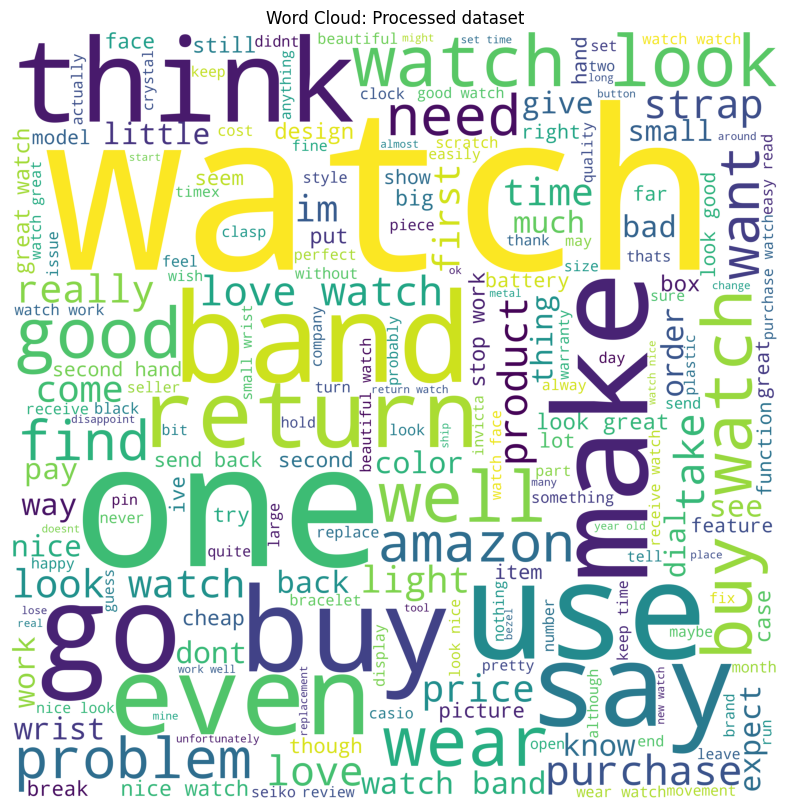

In [34]:
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.title("Word Cloud: Processed dataset")
plt.show()

### N-grams

In [35]:
def get_n_gram(corpus: pd.Series, n: int=None, range: tuple=(2, 2)) -> list:
    """
        Returns n-grams from a corpus.

        ### Parameters
        corpus: pd.Series
            A dataframe series containing corpus.
        n: int 
            The number of n-grams to return.
        range: tuple
            The range of n-grams to return.

        ### Returns
        list: 
            List of top occurring n-grams
    """
    count_vector = CountVectorizer(ngram_range=range, stop_words='english').fit(corpus)
    bag_of_words =  count_vector.fit_transform(corpus)
    bg_sum = bag_of_words.sum(axis=0)
    words_freq = [(word, bg_sum[0, idx]) for word, idx in count_vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [36]:
# getting bi common words
bi_common_words = get_n_gram(df['processed_review'], 15)

In [37]:
bi_common_words

[('watch looks', 1328),
 ('bought watch', 1316),
 ('watch band', 1264),
 ('great watch', 1155),
 ('looking watch', 1152),
 ('love watch', 1143),
 ('nice watch', 1042),
 ('looks great', 940),
 ('stopped working', 939),
 ('second hand', 851),
 ('looks like', 805),
 ('easy read', 788),
 ('watch face', 749),
 ('like watch', 706),
 ('beautiful watch', 695)]

In [38]:
def visualization_n_gram(common_words: list, title: str) -> None:
    """
        Visualization of n-grams
        
        ### Parameters
        common_words: list
            list of common n_gram words 
            >>> [('chat gpt', 596),
                    ('character limit', 259),
                ]
        title: str
            Title of graph
        ### Return
        None
    """
    # Create a dataframe 
    vis_df = pd.DataFrame(common_words, columns=['Tweet', 'Count'])
    vis_df.plot(x='Tweet', y='Count', kind='bar', title=title, figsize=(8, 8))

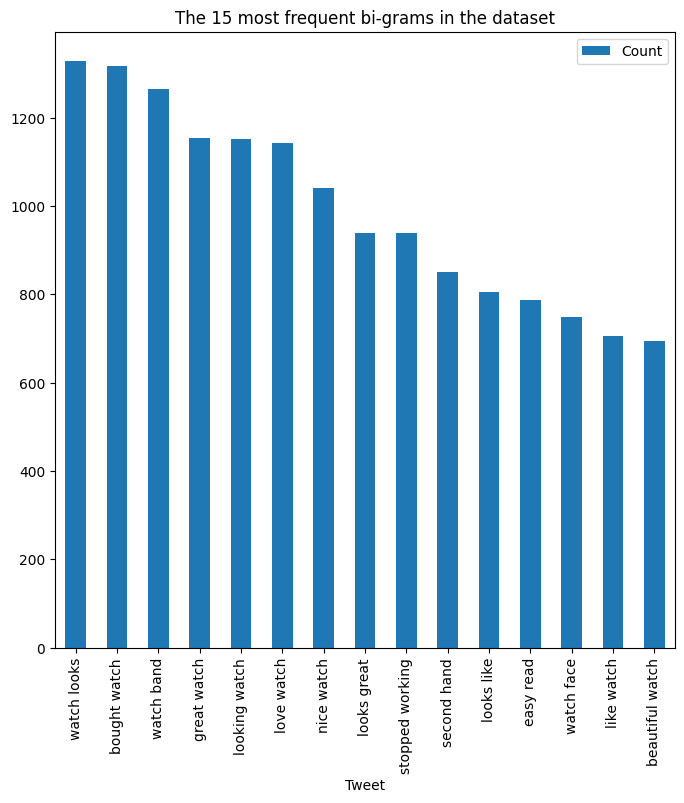

In [39]:
visualization_n_gram(common_words=bi_common_words, title='The 15 most frequent bi-grams in the dataset')

In [40]:
# getting tri common words
tri_common_words = get_n_gram(df['processed_review'], 15, range=(3,3))
tri_common_words

[('nice looking watch', 330),
 ('watch looks great', 257),
 ('watch stopped working', 234),
 ('great looking watch', 211),
 ('good looking watch', 203),
 ('watch looks good', 170),
 ('keeps good time', 169),
 ('really like watch', 137),
 ('don waste money', 123),
 ('watch looks like', 120),
 ('watch looks nice', 117),
 ('watch great price', 105),
 ('keeps perfect time', 105),
 ('highly recommend watch', 96),
 ('keeps great time', 83)]

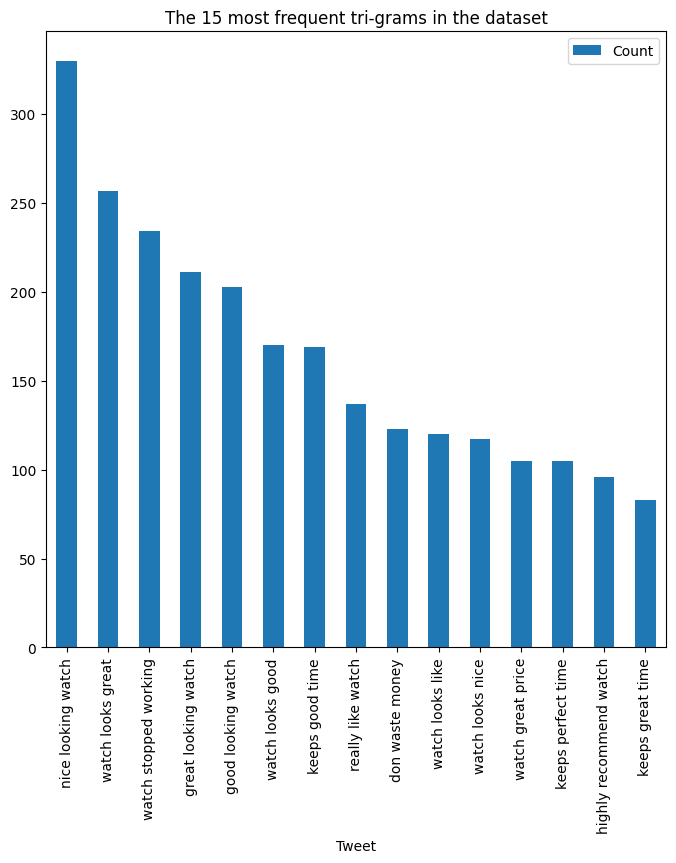

In [41]:
visualization_n_gram(common_words=tri_common_words, title='The 15 most frequent tri-grams in the dataset')

### Word Vectorization

In [33]:
df.head()

,Sentiment,short_review,processed_review,remove_punct,tokenized,remove_stopwords,pos_tag,text_lemmatizer
0,1,"It's exactly how it looks like, the colors are...","it's exactly how it looks like, the colors are...",its exactly how it looks like the colors are b...,"[its, exactly, how, it, looks, like, the, colo...","[exactly, looks, like, colors, bright, cant, w...","[(exactly, RB), (looks, VBZ), (like, IN), (col...","[exactly, look, like, color, bright, cant, wai..."
1,1,Very happy!,very happy!,very happy,"[very, happy]",[happy],"[(happy, JJ)]",[happy]
2,1,A great Watch for my Nurse wife. This is Ok bu...,a great watch for my nurse wife. this is ok bu...,a great watch for my nurse wife this is ok but...,"[a, great, watch, for, my, nurse, wife, this, ...","[great, watch, nurse, wife, ok, expendable, lo...","[(great, JJ), (watch, NN), (nurse, JJ), (wife,...","[great, watch, nurse, wife, ok, expendable, lo..."
3,1,"I've had a sector diver watch before ,it last...","i've had a sector diver watch before ,it laste...",ive had a sector diver watch before it lasted ...,"[ive, had, a, sector, diver, watch, before, it...","[ive, sector, diver, watch, lasted, years, sec...","[(ive, JJ), (sector, NN), (diver, NN), (watch,...","[ive, sector, diver, watch, last, year, sector..."
4,1,I have several different models. This is my cu...,i have several different models. this is my cu...,i have several different models this is my cur...,"[i, have, several, different, models, this, is...","[several, different, models, current, favorite...","[(several, JJ), (different, JJ), (models, NNS)...","[several, different, model, current, favorite,..."


In [42]:
#bag of words
count = CountVectorizer()
bag_of_words = count.fit_transform(df['text_lemmatizer'].apply(lambda x: " ".join(x)).tolist())
bag_of_words

<40000x29822 sparse matrix of type '<class 'numpy.int64'>'
	with 841458 stored elements in Compressed Sparse Row format>

In [43]:
df_bow = pd.DataFrame(bag_of_words.toarray(), columns=count.get_feature_names_out())
df_bow.sample(10)

,aa,aaa,aaaaaand,aaahs,aabout,aacutegua,aagain,aamazon,aan,aaround,...,zoo,zoom,zoomed,zootsuit,zub,zucker,zuedel,zulu,zurich,zwlaszcza
26732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df_bow.shape

(40000, 29822)

In [45]:
bow_features = " ".join(list(count.get_feature_names_out()))
bow_features[:100]

'aa aaa aaaaaand aaahs aabout aacutegua aagain aamazon aan aaround aatos ab ababa abaca abacas aback '

In [34]:
# tfidf
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
X = vectorizer.fit_transform(df['text_lemmatizer'].map(lambda x: ' '.join(x)).tolist())

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, df['Sentiment'], test_size=0.25, random_state=5)

In [36]:
X_train.shape, X_test.shape, Y_train.shape

((30000, 1056229), (10000, 1056229), (30000,))

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [38]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [39]:
from sklearn import metrics


In [40]:
predicted = MNB.predict(X_test)


In [41]:
accuracy_score = metrics.accuracy_score(predicted, Y_test)


In [42]:
accuracy_score

0.8698

In [44]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

In [47]:
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [48]:
df_tfidf.sample(10)

,aa,aa battery,aa battery inside,aa description,aa description say,aa meeting,aa meeting plate,aa problem,aa problem good,aaa,...,zulu time timer,zulu time work,zulu utc,zulu utc gmt,zurich,zurich make,zurich make authenticated,zwlaszcza,zwlaszcza jego,zwlaszcza jego skorzana
26744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df_tfidf.shape

(40000, 1056229)

In [50]:
tfidf_features = " ".join(list(vectorizer.get_feature_names_out()))
tfidf_features[:100]

'aa aa battery aa battery inside aa description aa description say aa meeting aa meeting plate aa pro'

### Word Cloud

In [51]:
#Bag of words -- word cloud
word_cloud_bow = WordCloud(
    width=3000,
    height=3000,
    stopwords=STOPWORDS,
    mode="RGBA",
    background_color='white',
).generate(bow_features)

#tfidf word cloud
word_cloud_tfidf= WordCloud(
    width=3000,
    height=3000,
    stopwords=STOPWORDS,
    mode="RGBA",
    background_color='white',
).generate(tfidf_features)

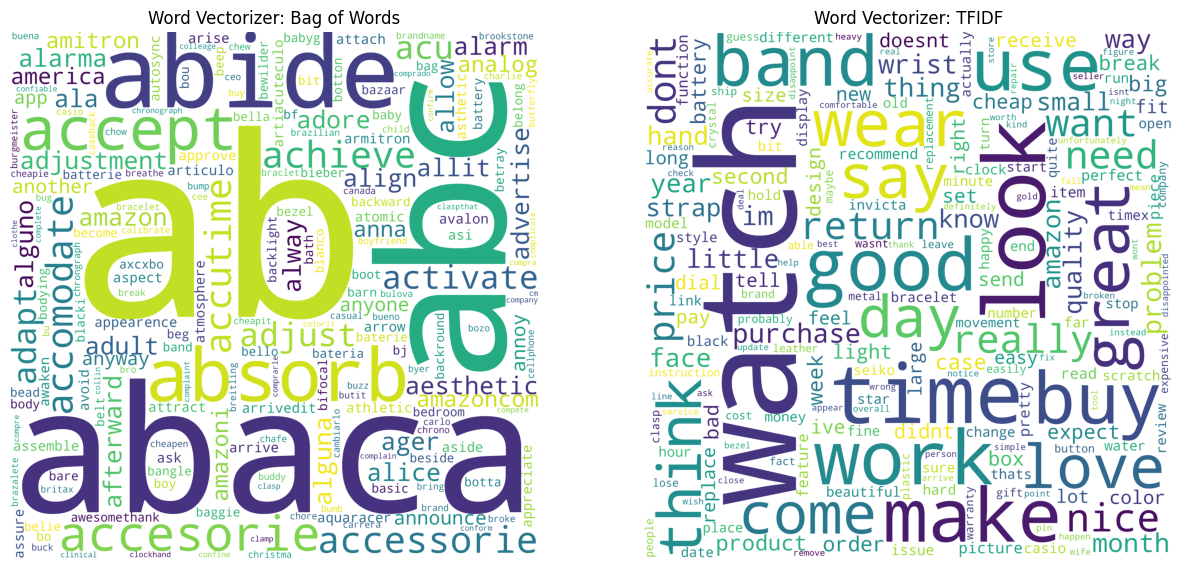

In [52]:
fig , ax  = plt.subplots(1, 2, figsize=(15,15), facecolor=None)
# plt.figure(figsize=(8, 8), facecolor=None)
ax[0].imshow(word_cloud_bow)
ax[0].axis('off')
ax[0].set_title("Word Vectorizer: Bag of Words")

ax[1].imshow(word_cloud_tfidf)
ax[1].axis('off')
ax[1].set_title("Word Vectorizer: TFIDF")
plt.show()

### Dimensionality Reduction -> Principal Component Analysis

In [53]:
from sklearn.decomposition import PCA
import numpy as np

# create a PCA object and specify the number of components to keep
pca = PCA(n_components=50)

# fit the PCA model to the data and transform it
X_pca = pca.fit_transform(df_tfidf)

# print the original data shape and the PCA transformed data shape
print("Original data shape: ", df_tfidf.shape)
print("Transformed data shape: ", X_pca.shape)

: 

: 

#### KMeans Clustering

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
# Building the clustering model and calculating the values of the Distortion and Inertia
distortions = []
inertias = []
clusters = range(1, 10)
# KMeans algorithm for cluster of 1 to 10
for k in clusters:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_pca)  
    distortions.append(sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X_pca.shape[0])
    inertias.append(kmeanModel.inertia_)

In [ ]:
# Tabulating and Visualizing the results using the different values of Distortion
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
# Tabulating and Visualizing the results using the different values of inertias
plt.plot(clusters, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()